In [15]:
import urllib.request, urllib.error
slothlib_path = 'http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt'
slothlib_file = urllib.request.urlopen(slothlib_path)
slothlib_stopwords = [line.decode("utf-8").strip() for line in slothlib_file]
slothlib_stopwords = [ss for ss in slothlib_stopwords if not ss==u'']
import warnings
warnings.filterwarnings("ignore")
import spacy
nlp = spacy.load('ja_ginza')
from parse_5w1h import parse_5w1h
#テストファイル読み込み&下処理
path = "/Users/shota/Documents/itac/test_summary1.txt"
with open(path) as f:
    text = f.read()
text = '金曜日の朝、ケンタッキー州の工業団地で巨大な火事が発生し、当局が被害を封じ込めようと働いたため、その地域に濃い煙が噴出した。市の緊急管理機関のマイク・ワイマー氏によると、ルイビルのゼネラル・エレクトリック・アプライアンス・パークで午前7時少し前に火災が始まりました。 彼は、負傷者や閉じ込められた者の報告はないと言った。 ビデオは煙と明るいオレンジ色の炎の両方を示しました。 消防士は影響を受けた建物の周りの位置を取り、周辺から水を噴霧しました。 ワイマーは、当局が火災の原因を知らなかったとCNNに語り、少なくとも4つの警報が鳴った。 GEのWebサイトによると、ルイビルアプライアンスパークの施設は、米国の製造業を活性化しています。 公園は大きく、34のサッカー場が施設内の倉庫の1つに収まるようになっています。'
text = text.replace('\n','')

print(text)
doc = nlp(text)

金曜日の朝、ケンタッキー州の工業団地で巨大な火事が発生し、当局が被害を封じ込めようと働いたため、その地域に濃い煙が噴出した。市の緊急管理機関のマイク・ワイマー氏によると、ルイビルのゼネラル・エレクトリック・アプライアンス・パークで午前7時少し前に火災が始まりました。 彼は、負傷者や閉じ込められた者の報告はないと言った。 ビデオは煙と明るいオレンジ色の炎の両方を示しました。 消防士は影響を受けた建物の周りの位置を取り、周辺から水を噴霧しました。 ワイマーは、当局が火災の原因を知らなかったとCNNに語り、少なくとも4つの警報が鳴った。 GEのWebサイトによると、ルイビルアプライアンスパークの施設は、米国の製造業を活性化しています。 公園は大きく、34のサッカー場が施設内の倉庫の1つに収まるようになっています。


In [16]:
from collections import defaultdict

# 1. 単語の頻度をカウント
word2freq = defaultdict(int)
word_list = []
for sent in doc.sents:
    word_list = [word.text for word in sent] 
    for word in set(word_list) :
            word2freq[word] += 1
print("語彙サイズ: %d" % len(word2freq.keys()))

語彙サイズ: 109


In [17]:
# 2. 語彙制限（高頻度な500単語に制限）

vocab = list()
for word, freq in sorted(word2freq.items(), key=lambda x: x[1], reverse=True)[:500]:
    vocab.append(word)
print("語彙サイズ: %d" % len(vocab))

語彙サイズ: 109


In [18]:
# 3. 各単語にIDを割り当てる

word2id = dict()
for word in vocab:
    word2id[word] = len(word2id)
print("単語 ケンタッキー州のID: %s" % word2id["ケンタッキー州"])

単語 ケンタッキー州のID: 32


In [21]:
# 2. TFIDFの計算
def tfidf(word, word_list, word2freq, n):
    return (word_list.count(word) / len(word_list)) * math.log(n / word2freq[word])

In [22]:
# 3. BoWの重み付け
import math
import numpy as np
def tfidf_vectorize(sent, vocab, word2id, word2df, n):
    vectors = list()
    
    word_list = [token.text for token in sent ]
    vector = np.zeros(len(vocab))
    for word in word_list:
        if word in vocab:
            vector[word2id[word]] = tfidf(word, word_list, word2df, n)
    return vector

In [7]:
import networkx as nx
sent_list = []
sent_vectors = []
graph = nx.Graph()

node_id = 0
for sent in doc.sents:
    if sent.text not in sent_list:
        sent_list.append(sent.text)
        graph.add_node(node_id)
        vector = tfidf_vectorize(sent,vocab,word2id,word2freq, len([1 for token in sent])) 
        sent_vectors.append(vector)
        node_id += 1

In [24]:
sent_vectors[1].shape

(109,)

In [8]:
# コサイン類似度の計算
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        

In [9]:
def increment_edge (graph, node0, node1):
    print("link {} {}".format(node0, node1))
    
    if graph.has_edge(node0, node1):
        graph[node0][node1]["weight"] += 1.0
    else:
        graph.add_edge(node0, node1, weight=1.0)

In [10]:
#類似度が0以上の場合edgeで繋ぐ
for i, vector1 in enumerate(sent_vectors[:-2]):
    for l,vector2 in enumerate(sent_vectors[i+1:],i+1):
        if cos_sim(vector1,vector2) > 0.2:
            increment_edge(graph, i, l)

link 0 5
link 1 5
link 1 6


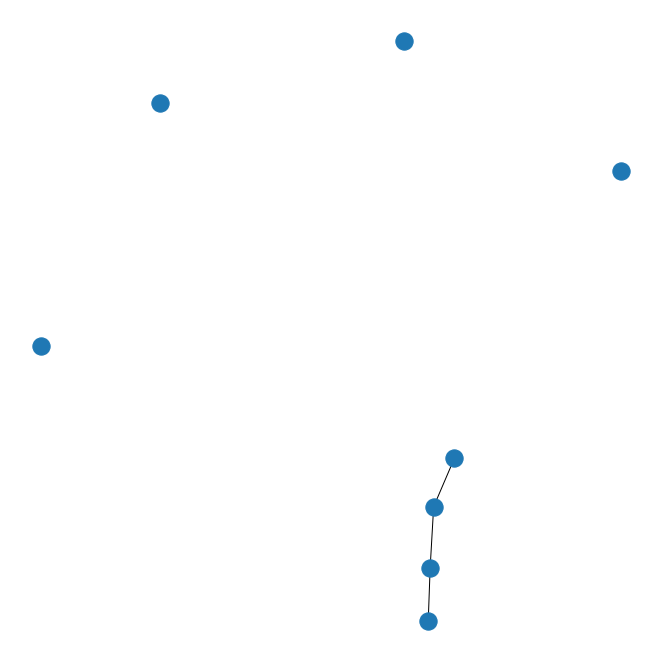

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9, 9))
pos = nx.spring_layout(graph)

nx.draw(graph, pos=pos, with_labels=False, font_weight="bold")

In [12]:
ranks = nx.pagerank(graph)

In [25]:
for node_id, rank in sorted(ranks.items(), key=lambda x: x[1], reverse=True):
    print(sent_list[node_id])

ワイマーは、当局が火災の原因を知らなかったとCNNに語り、少なくとも4つの警報が鳴った。
市の緊急管理機関のマイク・ワイマー氏によると、ルイビルのゼネラル・エレクトリック・アプライアンス・パークで午前7時少し前に火災が始まりました。
GEのWebサイトによると、ルイビルアプライアンスパークの施設は、米国の製造業を活性化しています。
金曜日の朝、ケンタッキー州の工業団地で巨大な火事が発生し、当局が被害を封じ込めようと働いたため、その地域に濃い煙が噴出した。
彼は、負傷者や閉じ込められた者の報告はないと言った。
ビデオは煙と明るいオレンジ色の炎の両方を示しました。
消防士は影響を受けた建物の周りの位置を取り、周辺から水を噴霧しました。
公園は大きく、34のサッカー場が施設内の倉庫の1つに収まるようになっています。


In [ ]:
#金曜日の朝、ケンタッキー州の工業団地で巨大な火事が発生し、当局が被害を封じ込めようと働いたため、その地域に濃い煙が噴出した。
#彼は、負傷者や閉じ込められた者の報告はないと言った。
#消防士は影響を受けた建物の周りの位置を取り、周辺から水を噴霧しました。
#ワイマーは、当局が火災の原因を知らなかったとCNNに語り、少なくとも4つの警報が鳴った。
#公園は大きく、34のサッカー場が施設内の倉庫の1つに収まるようになっています。

